# Exercise 4: Mandatory Assignment

## Project Imports

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.font_manager
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import scipy as sp
import pylab as P
import random

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
labels_dictionary = {0.0: "Blue",
                     1.0: "Brown",
                     2.0: "Green",
                     3.0: "Grey",
                     4.0: "Orange",
                     5.0: "Pink",
                     6.0: "Purple",
                     7.0: "Red",
                     8.0: "White",
                     9.0: "Yellow"}

# 1. Load the prepared training set

##  First run "!ls" command to check if it's already in the vm

In [4]:
!mkdir BAK
!cp *.csv BAK/
!rm *.csv
!ls

cp: cannot stat '*.csv': No such file or directory
rm: cannot remove '*.csv': No such file or directory
BAK  datalab


## Download the train dataset from the cloud storage

In [0]:
downloaded = drive.CreateFile({'id': '1mwrxBXZsgHLFO9IpWYXNfUFJnLT5yraj'})
downloaded.GetContentFile('train_X.csv')

downloaded = drive.CreateFile({'id': '1FHPumn9bdXiLzO5tbpGGrcvxzNpoCG0Z'})
downloaded.GetContentFile('train_y.csv')

In [6]:
!ls

BAK  datalab  train_X.csv  train_y.csv


## Load the train set into dataframes (X, y)

In [0]:
train_X =      pd.read_csv("train_X.csv", header=0)
train_y =      pd.read_csv("train_y.csv", header=None)
#train_y.columns = ["Vote"]

# fix df_label as df_label[0] for easy writing..
train_y_values = train_y[0]

## View the loaded training set

In [8]:
train_X.info()
train_X.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  5831 non-null float64
Yearly_IncomeK                                   5831 non-null float64
Overall_happiness_score                          5831 non-null float64
Avg_Satisfaction_with_previous_vote              5831 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    5831 non-null float64
Weighted_education_rank                          5831 non-null float64
Will_vote_only_large_party_1.0                   5831 non-null int64
Will_vote_only_large_party_0.0                   5831 non-null int64
Will_vote_only_large_party_2.0                   5831 non-null int64
Most_Important_Issue_4.0                         5831 non-null int64
Most_Important_Issue_1.0                         5831 non-null int64
Most_Important_Issue_7.0                         5831 non-null int64
Most_Important_Issue_5.0                         5831

,Number_of_valued_Kneset_members,Yearly_IncomeK,Overall_happiness_score,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Weighted_education_rank,Will_vote_only_large_party_1.0,Will_vote_only_large_party_0.0,Will_vote_only_large_party_2.0,Most_Important_Issue_4.0,Most_Important_Issue_1.0,Most_Important_Issue_7.0,Most_Important_Issue_5.0,Most_Important_Issue_2.0,Most_Important_Issue_0.0,Most_Important_Issue_6.0,Most_Important_Issue_3.0
0,9.0,-1.135556,-4.210137,2.806640,-0.919437,3.395327,0,0,1,0,0,0,0,1,0,0,0
1,14.0,-0.674079,0.886686,1.802433,-0.102686,-0.133469,0,0,1,0,0,0,0,0,1,0,0
2,8.0,-0.965695,0.340745,-0.450976,0.477329,-0.416028,0,1,0,0,0,0,1,0,0,0,0
3,6.0,-0.093311,-0.093619,-0.650299,0.733155,-1.309064,1,0,0,0,0,0,0,1,0,0,0
4,6.0,2.259453,0.146151,0.304831,2.579338,0.818161,1,0,0,0,0,1,0,0,0,0,0


In [9]:
train_X['Yearly_IncomeK'][1:10]

1   -0.674079
2   -0.965695
3   -0.093311
4    2.259453
5   -0.244088
6   -0.991094
7   -3.341957
8    2.049615
9   -0.432860
Name: Yearly_IncomeK, dtype: float64

In [10]:
train_y.head(5)

,0
0,0.0
1,0.0
2,4.0
3,1.0
4,5.0


##Split the train dataset by each party

In [0]:
def group_by_count(list):
  result = {}
  for item in list:
    if item in result:
      result[item] += 1
    else:
      result[item] = 1
  return result

def display_parties_count(y):
  parties_samples = group_by_count(y[0])
  print "Party | Count"
  print "----- | -----"
  for party, count in parties_samples.iteritems():
    print "{0}   | {1}".format(party, count)
  print "----- | -----"
  print "Total | {0}".format(len(y[0]))
  
def get_parties_dataframes(X, y):
  parties_dataframes_dictionary = {}
  for party in labels_dictionary.keys():
    party_samples_indexes = y.index[y[0] == party].tolist()
    print len(party_samples_indexes)
    parties_dataframes_dictionary[party] = X.loc[party_samples_indexes]
  return parties_dataframes_dictionary

In [12]:
display_parties_count(train_y)

Party | Count
----- | -----
0.0   | 484
1.0   | 1115
2.0   | 977
3.0   | 331
4.0   | 320
5.0   | 627
6.0   | 1240
7.0   | 325
8.0   | 202
9.0   | 210
----- | -----
Total | 5831


In [13]:
train_parties_dataframes_dictionary = get_parties_dataframes(train_X, train_y)

484
1115
977
331
320
627
1240
325
202
210


## Histogram of a Feature distribution across all Parties

In [0]:
def plot_variable_hist(xlabel=None, ylabel='Voters'):
  for i in labels_dictionary:
    Mean = "Mean: " + str(round(train_parties_dataframes_dictionary[i][xlabel].mean(), 3))
    STD = "STD: " + str(round(train_parties_dataframes_dictionary[i][xlabel].std(), 3))
    label2 = labels_dictionary[i] + "\n" + Mean + "\n" + STD
    plt.hist(train_parties_dataframes_dictionary[i][xlabel], label=label2, facecolor=labels_dictionary[i], histtype='step', stacked=True, fill=True, alpha=0.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(str(xlabel) + ' Dists')
  plt.grid(True)
  plt.legend(loc='upper right')
  return plt

### Key Features we want plot (from previous exercise)
1.   Yearly_IncomeK (0.83860384)
2.   Overall_happiness_score (0.91973599)
3.   Garden_sqr_meter_per_person_in_residancy_area (1.0)
4.   Weighted_education_rank (0.90815924)


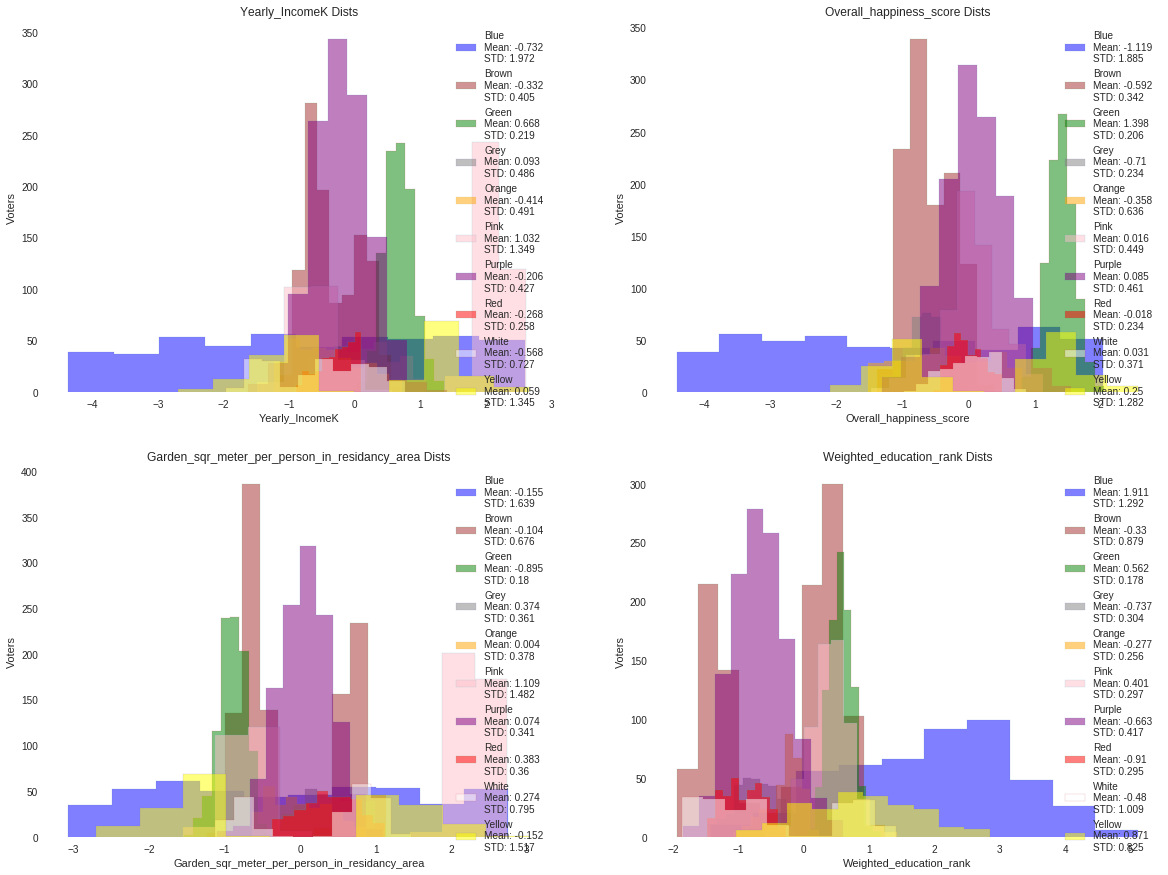

In [15]:
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams['axes.facecolor'] = 'white'

fig_size[0] = 20
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
 
plt.subplot(2, 2, 1)
plt = plot_variable_hist(xlabel='Yearly_IncomeK')

plt.subplot(2, 2, 2)
plt = plot_variable_hist(xlabel='Overall_happiness_score')

plt.subplot(2, 2, 3)
plt = plot_variable_hist(xlabel='Garden_sqr_meter_per_person_in_residancy_area')

plt.subplot(2, 2, 4)
plt = plot_variable_hist(xlabel='Weighted_education_rank')

#2. Train at least one generative model and one clustering model

## Each training should be done via cross-validation on the training set, to maximize performance of the model while avoiding overfitting

##  Generative Classifier Models

The best performance of the model is with the default configuration, and that's the way we train out models

In [0]:
from sklearn.model_selection import cross_val_score

def train_model_via_cross_validation(cls, X, y, k=10):
  scores = cross_val_score(cls, X, y, cv=k)
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  return cls

###LDA - Linear Discriminant Analysis

####Initialization

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

####Train The Model

In [18]:
lda = train_model_via_cross_validation(LinearDiscriminantAnalysis(), train_X, train_y_values)

Accuracy: 0.82 (+/- 0.03)


/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


###Naive Bayes

####Initialization

In [0]:
from sklearn.naive_bayes import GaussianNB

####Train The Model

In [20]:
gnb = train_model_via_cross_validation(GaussianNB(), train_X, train_y_values)

Accuracy: 0.88 (+/- 0.01)


###Choose Generative Model (Manual) and Fit dataset

In [21]:
generative_model = gnb
generative_model.fit(train_X, train_y)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

##  Clustering Models

### GMM - GaussianMixture

####Find Optimal GMM Configuration

In [0]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

plt.rcParams.update(plt.rcParamsDefault)

def silhouette_func(X, Y, GMM_array, number_of_gaussians):
  cluster_counter=0
  for n_clusters in number_of_gaussians:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    #fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.15, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    cluster_model_description, cluster_model = GMM_array[cluster_counter]
    cluster_model.fit(X)
    cluster_labels = cluster_model.predict(X)
        
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()
    cluster_counter += 1

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import GaussianMixture as GMM

plt.rcParams.update(plt.rcParamsDefault)

def find_best_GMM_configuration(train_X, train_y, GMM_array, number_of_gaussians, k_folds = 10):
  """
  Using KFold on the train set, and AIC & BIC for evaluation and choosing Hyper-Parameters
  run cross-validation on train-set with all GMMs:
  NOTE: lets talk about our consideration whether to use Stratified sampling in KFold or not:
        - we know that our data is NOT balanced across the different classes (since some parties are much bigger than others)
        - BUT, we assumed that the ERROR of our model is balanced across the classes, and THIS IS WHAT MATTER!
        - So, we've verified this assumption by empiricli check the results of both Stratified and UnStratified KFold:
        + and indeed, they came up nearly identical. 
        ++ So, we can say that most likely - our assumption was good and we can use Stratified KFold. :)
  """
  bic_arr = []
  aic_arr = []
  kf = StratifiedKFold(n_splits=k_folds)
  kf.get_n_splits(train_X)
  
  for name, cls in GMM_array:
    aic = 0
    bic = 0

    for (train_index, test_index) in kf.split(train_X, train_y):
      ## NOTE: using label (train_y) while training GMM is using External evaluation method
      ##       which checks the Purity of the created clusters (i.e, how much the clusters consist of one class... how much they are Monotonous)
      cls.fit(train_X.iloc[train_index], train_y.iloc[train_index])
      #cls.fit(train_X.iloc[train_index], y=None)
      y_pred = cls.predict(train_X.iloc[test_index])
      aic = aic + cls.aic(train_X.iloc[test_index])
      bic = bic + cls.bic(train_X.iloc[test_index])

    avg_aic = aic / k_folds
    avg_bic = bic / k_folds
    bic_arr.append(avg_bic)
    aic_arr.append(avg_aic)
    print(name + " has scored AIC: " + str(avg_aic) + " and BIC: " + str(avg_bic))
  
  ## plot AIC and BIC parameters for each GMM
  fig_size = plt.rcParams["figure.figsize"]
  fig_size[0] = 15
  fig_size[1] = 5
  plt.rcParams["figure.figsize"] = fig_size

  plt.subplot(1, 2, 1)
  plt.plot(number_of_gaussians, bic_arr)
  plt.title('BIS by Number of Gaussians')
  plt.ylabel('BIS')
  plt.xlabel('Number of Gaussians')
  plt.annotate('Local Minimum', xy=(30, -58500), xytext=(20, -42500), arrowprops=dict(facecolor='black', shrink=0.05),)

  plt.subplot(1, 2, 2)
  plt.plot(number_of_gaussians, aic_arr)
  plt.title('AIS by Number of Gaussians')
  plt.ylabel('AIS')
  plt.xlabel('Number of Gaussians')

#### GMM clustering hyperparameter optimization - choose number of gaussians

##### AIC & BIC Scoring

GMM with 5 components has scored AIC: -36704.16737008634 and BIC: -35944.07456591194
GMM with 10 components has scored AIC: -51440.432125998814 and BIC: -49915.87816820075
GMM with 15 components has scored AIC: -56649.27411652566 and BIC: -54360.259005103915
GMM with 20 components has scored AIC: -59606.05817987609 and BIC: -56552.58191483068
GMM with 25 components has scored AIC: -61851.13345995871 and BIC: -58033.19604128964
GMM with 30 components has scored AIC: -62854.77092244051 and BIC: -58272.37235014775
GMM with 40 components has scored AIC: -63272.50515173325 and BIC: -57161.18427219313
GMM with 50 components has scored AIC: -63458.62285225303 and BIC: -55818.37966546558


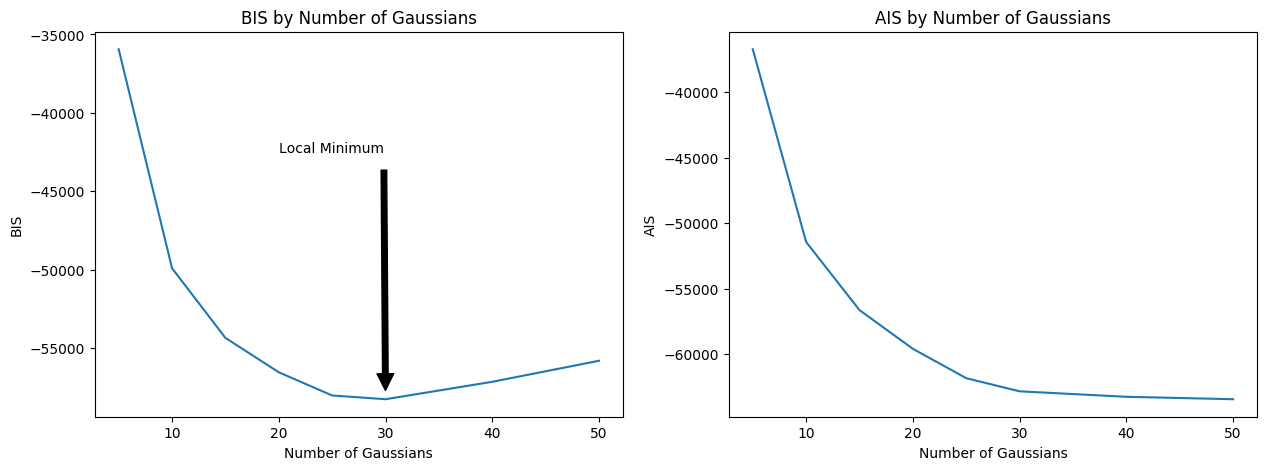

In [28]:
GMM_description = []
GMM_cls = []
gaussians_componenets = [5, 10, 15, 20, 25, 30, 40, 50]

for components in gaussians_componenets:
  GMM_description.append("GMM with {0} components".format(components))
  GMM_cls.append(GMM(n_components=components, covariance_type='diag'))
  #GMM_cls.append(GMM(n_components=components, max_iter=200, random_state=0))


GMM_array = zip(GMM_description, GMM_cls)
find_best_GMM_configuration(train_X, train_y, GMM_array, gaussians_componenets)

##### Silhouette Scoring

('For n_clusters =', 5, 'The average silhouette_score is :', 0.009106979229309583)


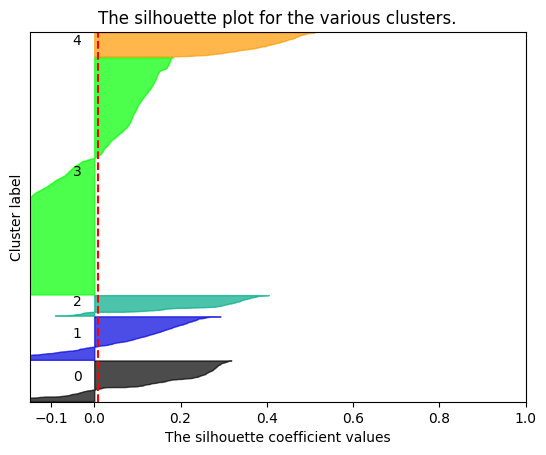

('For n_clusters =', 10, 'The average silhouette_score is :', -0.0016016930168085985)


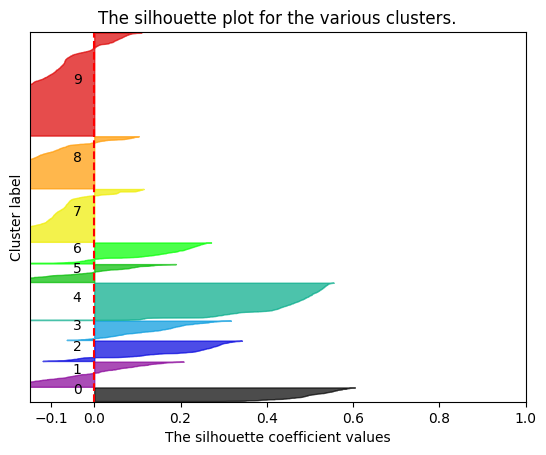

('For n_clusters =', 15, 'The average silhouette_score is :', -0.05010101694778677)


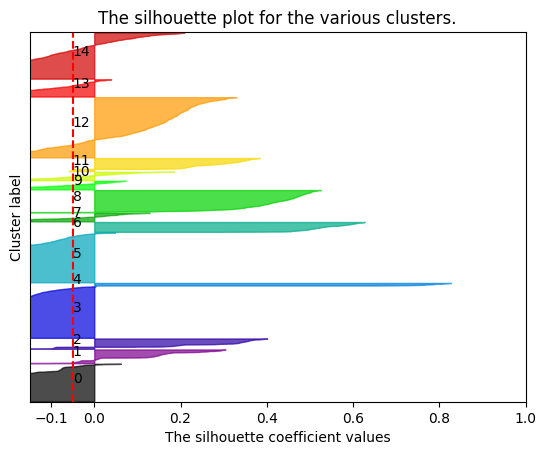

('For n_clusters =', 20, 'The average silhouette_score is :', -0.03782226281030915)


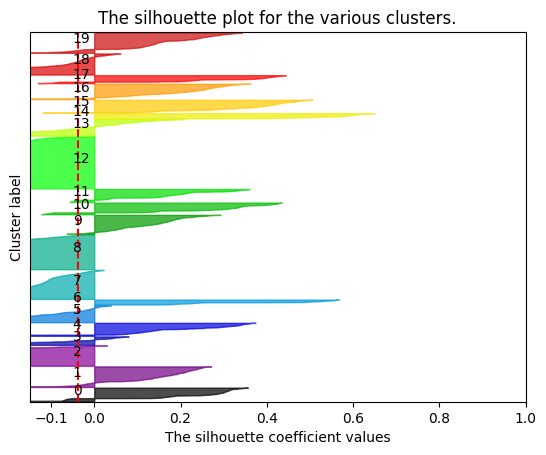

('For n_clusters =', 25, 'The average silhouette_score is :', -0.008614351591929262)


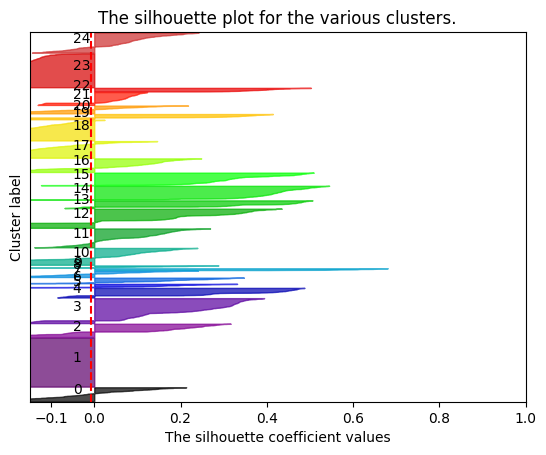

('For n_clusters =', 30, 'The average silhouette_score is :', -0.1064802013176798)


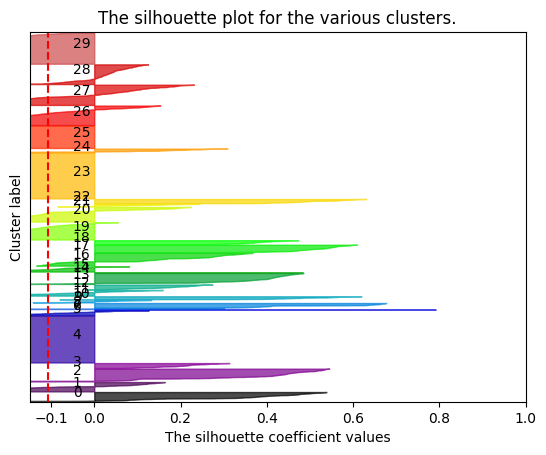

('For n_clusters =', 40, 'The average silhouette_score is :', -0.0981458109435932)


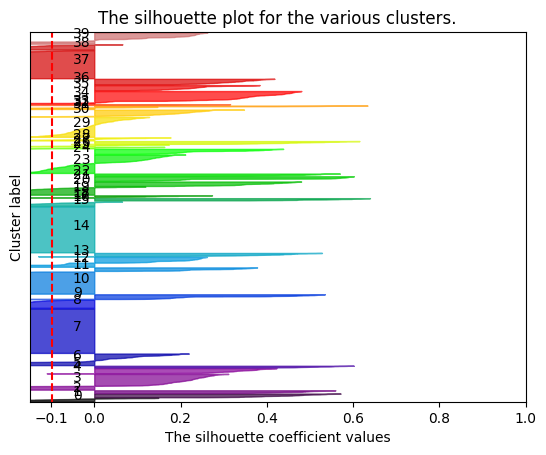

('For n_clusters =', 50, 'The average silhouette_score is :', -0.001282868862481758)


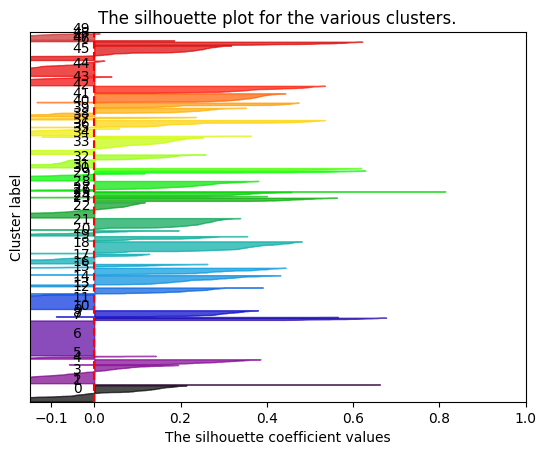

In [32]:
silhouette_func(train_X, train_y, GMM_array, gaussians_componenets)

####Automate Empiric Evaluation using GridSearchCV and CV

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

tuned_parameters = {'n_components': gaussians_componenets, 
                    'covariance_type': ['diag']}

clf = GridSearchCV(GMM(), tuned_parameters, cv=StratifiedKFold(n_splits=10), scoring='precision_weighted')
clf.fit(train_X, train_y)
print "Best parameters set found on training set: {0}, with score: {1}".format(clf.best_params_, clf.best_score_)

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on training set: {'covariance_type': 'diag', 'n_components': 15}, with score: 0.200249338286


###Choose Clustering Model Configuration (Manual) and Fit dataset 

In [35]:
clusters_number = 30
cluster_model_description, cluster_model = GMM_array[5]
cluster_model.fit(train_X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=30, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

# 3. Load the prepared valid set

## Download the train dataset from the cloud storage

In [0]:
downloaded = drive.CreateFile({'id': '1HgtZC1iq9VYH8Ygo6-6XnC6G0xa8Lz01'})
downloaded.GetContentFile('validation_X.csv')

downloaded = drive.CreateFile({'id': '1Z_0zOORoZJVlOQ58UdXml4maSNSNBBMK'})
downloaded.GetContentFile('validation_y.csv')

In [37]:
!ls

BAK  datalab  train_X.csv  train_y.csv	validation_X.csv  validation_y.csv


## Load the train set into dataframes (X, y)

In [0]:
valid_X =      pd.read_csv("validation_X.csv", header=0)
valid_y =      pd.read_csv("validation_y.csv", header=None)
# valid_y.columns = ["Vote"]

# fix df_label as df_label[0] for easy writing..
valid_y_values = valid_y[0]

## View the loaded training set

In [39]:
valid_X.info()
valid_X.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  1944 non-null float64
Yearly_IncomeK                                   1944 non-null float64
Overall_happiness_score                          1944 non-null float64
Avg_Satisfaction_with_previous_vote              1944 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    1944 non-null float64
Weighted_education_rank                          1944 non-null float64
Will_vote_only_large_party_1.0                   1944 non-null int64
Will_vote_only_large_party_0.0                   1944 non-null int64
Will_vote_only_large_party_2.0                   1944 non-null int64
Most_Important_Issue_4.0                         1944 non-null int64
Most_Important_Issue_1.0                         1944 non-null int64
Most_Important_Issue_7.0                         1944 non-null int64
Most_Important_Issue_5.0                         1944

,Number_of_valued_Kneset_members,Yearly_IncomeK,Overall_happiness_score,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Weighted_education_rank,Will_vote_only_large_party_1.0,Will_vote_only_large_party_0.0,Will_vote_only_large_party_2.0,Most_Important_Issue_4.0,Most_Important_Issue_1.0,Most_Important_Issue_7.0,Most_Important_Issue_5.0,Most_Important_Issue_2.0,Most_Important_Issue_0.0,Most_Important_Issue_6.0,Most_Important_Issue_3.0
0,12.0,-0.107043,-0.141038,0.691124,-0.480667,-0.275633,1,0,0,0,1,0,0,0,0,0,0
1,8.0,1.872975,-0.189318,-0.721718,1.867954,-0.110044,1,0,0,0,0,1,0,0,0,0,0
2,12.0,0.788380,1.631465,0.520939,-0.703350,0.511250,1,0,0,0,0,0,0,1,0,0,0
3,8.0,-0.098471,0.059599,0.688121,0.682170,-1.322242,1,0,0,1,0,0,0,0,0,0,0
4,9.0,-0.042849,0.565714,0.591769,-0.113672,-0.630451,1,0,0,0,0,1,0,0,0,0,0


In [40]:
valid_y.head(5)

,0
0,6.0
1,5.0
2,2.0
3,8.0
4,6.0


##Split the train dataset by each party

In [41]:
display_parties_count(valid_y)

Party | Count
----- | -----
0.0   | 162
1.0   | 372
2.0   | 326
3.0   | 110
4.0   | 107
5.0   | 209
6.0   | 413
7.0   | 108
8.0   | 67
9.0   | 70
----- | -----
Total | 1944


In [42]:
valid_parties_dataframes_dictionary = get_parties_dataframes(valid_X, valid_y)

162
372
326
110
107
209
413
108
67
70


# 4. Apply the trained models on the valid set and check performance

##Utilities

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print title
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + " Plot")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##Apply Generative Model on the Valid set

In [44]:
predicted_y = generative_model.predict(valid_X)
print "Predictions on valid dataset:"
print "-------------------------------"
display_parties_count([predicted_y])
print ""
print "Labels values from valid dataset:"
print "---------------------------------"
display_parties_count(valid_y)

Predictions on valid dataset:
-------------------------------
Party | Count
----- | -----
0.0   | 165
1.0   | 424
2.0   | 325
3.0   | 102
4.0   | 120
5.0   | 158
6.0   | 423
7.0   | 103
8.0   | 57
9.0   | 67
----- | -----
Total | 1944

Labels values from valid dataset:
---------------------------------
Party | Count
----- | -----
0.0   | 162
1.0   | 372
2.0   | 326
3.0   | 110
4.0   | 107
5.0   | 209
6.0   | 413
7.0   | 108
8.0   | 67
9.0   | 70
----- | -----
Total | 1944


##Check Generative Model Performance

Performance measurement for GaussianNB classifier:
--------------------------------------------------
Accuracy Score: 0.880144032922.

Confusion Matrix:
             precision    recall  f1-score   support

        0.0       0.87      0.88      0.87       162
        1.0       0.79      0.90      0.84       372
        2.0       1.00      0.99      1.00       326
        3.0       0.95      0.88      0.92       110
        4.0       0.86      0.96      0.91       107
        5.0       0.92      0.69      0.79       209
        6.0       0.91      0.93      0.92       413
        7.0       0.98      0.94      0.96       108
        8.0       0.53      0.45      0.48        67
        9.0       0.72      0.69      0.70        70

avg / total       0.88      0.88      0.88      1944

Confusion Matrix
[[143   0   0   0   0   0   0   0   0  19]
 [  0 336   0   0   0   0  14   0  22   0]
 [  0   0 324   0   0   1   1   0   0   0]
 [  0   0   0  97  11   0   0   2   0   0]
 [  0   0   0   4 1

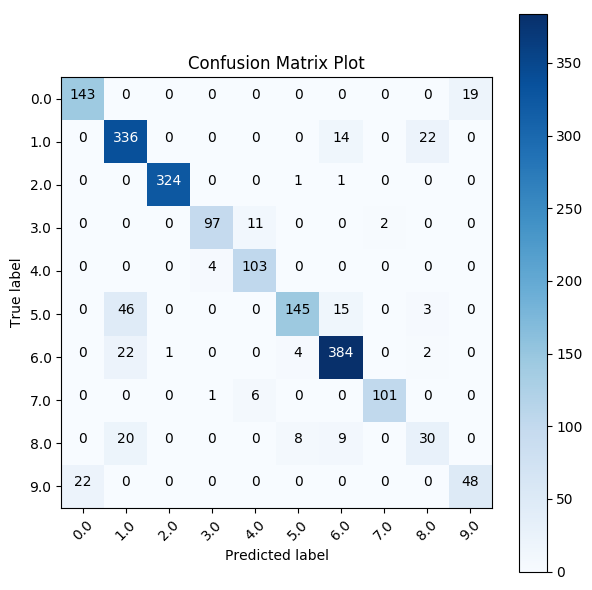

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print "Performance measurement for GaussianNB classifier:"
print "--------------------------------------------------"
print "Accuracy Score: {0}.".format(accuracy_score(valid_y, predicted_y))
print ""
class_report = classification_report(valid_y, predicted_y, target_names=[str(label) for label in labels_dictionary.keys()])
print "Confusion Matrix:"
print class_report
conf_matrix = confusion_matrix(valid_y, predicted_y)
np.set_printoptions(precision=2)
plt.figure(figsize = (6,6))
plot_confusion_matrix(conf_matrix, labels_dictionary.keys(), False, "Confusion Matrix", plt.cm.Blues)
plt.show()

##Apply Clustering Model on the Valid dataset 

In [46]:
cluster_labels = cluster_model.predict(valid_X)
print cluster_labels

[ 8 16  9 ... 18 16 19]


##Check Clustering Performance and Parties Preferences

### Silhouette Performance Score:
a value near +1 indicates that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

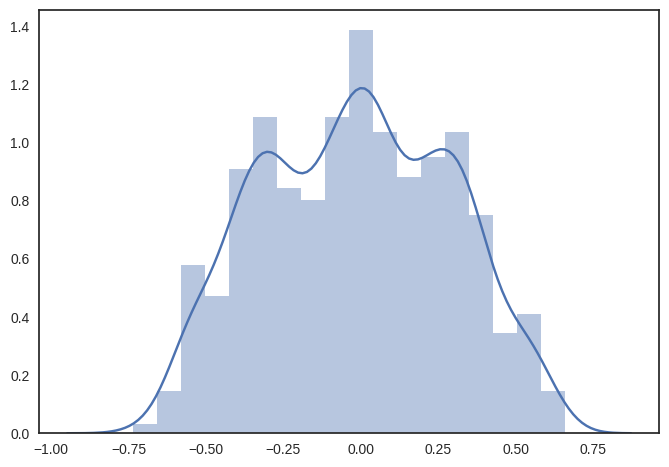

In [48]:
from sklearn import metrics
import seaborn as sns
sns.set(style="white", color_codes=True)

# note that this is the mean over all the samples - there might be some clusters 
# that are well separated and others that are closer together. 
# so let's look at the distribution of silhouette scores...
scores = metrics.silhouette_samples(valid_X, cluster_labels)
sns.distplot(scores)

#### Silhouette score of each Party (label)

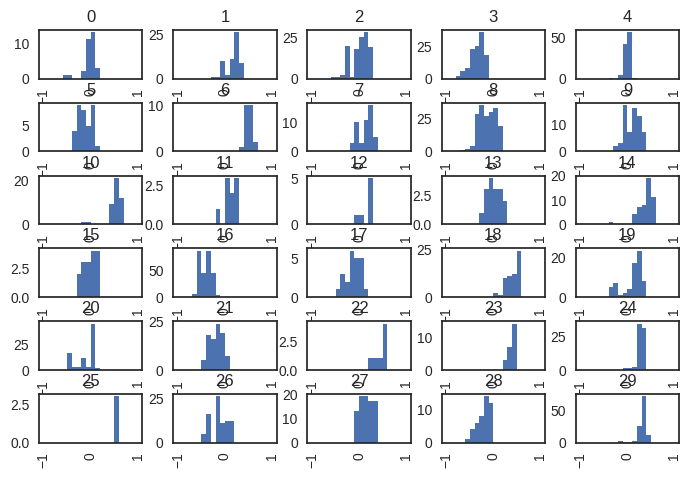

In [49]:
df_scores = pd.DataFrame()
df_scores['SilhouetteScore'] = scores
df_scores['cluster_labels'] = cluster_labels
df_scores.hist(by='cluster_labels', column='SilhouetteScore', range=(-1.0,1.0), bins=20);

### AIC & BIC Performance Check 

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import GaussianMixture as GMM

def check_GMM_on_valid_set(train_X, train_y, valid_X, valid_y, GMM_array, number_of_gaussians):
  """
  Using KFold on the train set, and AIC & BIC for evaluation and choosing Hyper-Parameters
  run cross-validation on train-set with all GMMs:
  NOTE: lets talk about our consideration whether to use Stratified sampling in KFold or not:
        - we know that our data is NOT balanced across the different classes (since some parties are much bigger than others)
        - BUT, we assumed that the ERROR of our model is balanced across the classes, and THIS IS WHAT MATTER!
        - So, we've verified this assumption by empiricli check the results of both Stratified and UnStratified KFold:
        + and indeed, they came up nearly identical. 
        ++ So, we can say that most likely - our assumption was good and we can use Stratified KFold. :)
  """
  bic_arr = []
  aic_arr = []

  for name, cls in GMM_array:
    cls.fit(train_X, train_y)
    y_pred = cls.predict(valid_X)
    aic = cls.aic(valid_X)
    bic = cls.bic(valid_X)
    aic_arr.append(aic)
    bic_arr.append(bic)
    print(name + " has scored AIC: " + str(aic) + " and BIC: " + str(bic))
    
  ## plot AIC and BIC parameters for each GMM
  fig_size = plt.rcParams["figure.figsize"]
  fig_size[0] = 15
  fig_size[1] = 5
  plt.rcParams["figure.figsize"] = fig_size

  plt.subplot(1, 2, 1)
  plt.plot(number_of_gaussians, bic_arr)
  plt.title('BIC by Number of Gaussians')
  plt.ylabel('BIC')
  plt.xlabel('Number of Gaussians')
  plt.annotate('Again! Local Minimum', xy=(30, -200000), xytext=(20, -140000), arrowprops=dict(facecolor='black', shrink=0.05),)

  plt.subplot(1, 2, 2)
  plt.plot(number_of_gaussians, aic_arr)
  plt.title('AIC by Number of Gaussians')
  plt.ylabel('AIC')
  plt.xlabel('Number of Gaussians')

GMM with 5 components has scored AIC: -139935.9268666556 and BIC: -138966.31134726203
GMM with 10 components has scored AIC: -184596.32228177803 and BIC: -182651.5187400059
GMM with 15 components has scored AIC: -176970.85821821884 and BIC: -174050.86665406817
GMM with 20 components has scored AIC: -196706.28171711782 and BIC: -192811.10213058858
GMM with 25 components has scored AIC: -210787.4311288143 and BIC: -205917.0635199065
GMM with 30 components has scored AIC: -214039.6999955892 and BIC: -208194.14436430283
GMM with 40 components has scored AIC: -217240.83463811033 and BIC: -209444.90296206682
GMM with 50 components has scored AIC: -221352.73285908598 and BIC: -211606.42513828533


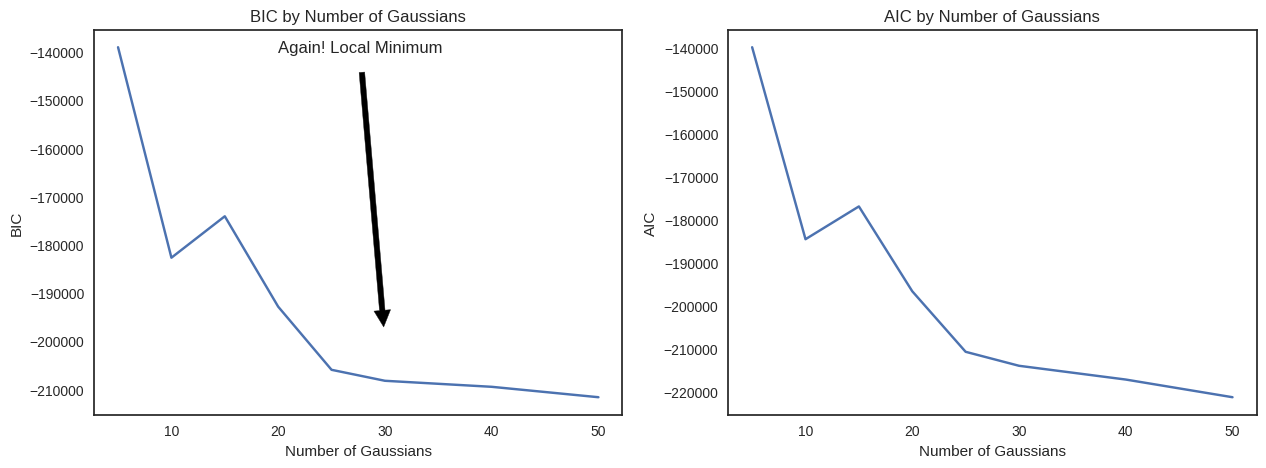

In [85]:
GMM_description = []
GMM_cls = []
gaussians_componenets = [5, 10, 15, 20, 25, 30, 40, 50]

for components in gaussians_componenets:
  GMM_description.append("GMM with {0} components".format(components))
  GMM_cls.append(GMM(n_components=components, covariance_type='diag'))

GMM_array = zip(GMM_description, GMM_cls)
check_GMM_on_valid_set(train_X, train_y, valid_X, valid_y, GMM_array, gaussians_componenets)

while the results of the GMMs on the training set (using cross-validation) were: 

1. GMM with 5 components has scored AIC: -40443.66314459931 and BIC: -39683.570340424914
2. GMM with 10 components has scored AIC: -52115.68433194302 and BIC: -50591.13037414495
3. GMM with 15 components has scored AIC: -57769.91517527682 and BIC: -55480.90006385507
4. GMM with 20 components has scored AIC: -59325.625906286434 and BIC: -56272.14964124104
5. GMM with 25 components has scored AIC: -61626.64983662559 and BIC: -57808.712417956514
6. GMM with 30 components has scored AIC: -63411.63809870374 and BIC: -58829.23952641097
7. GMM with 40 components has scored AIC: -63570.36142874011 and BIC: -57459.040549200006
8. GMM with 50 components has scored AIC: -63333.44366083441 and BIC: -55693.20047404695

# 5. Create a Steady Coalition

## Utilities

In [0]:
import operator

def get_parties_size(predicted_labels):
  parties_size = group_by_count(predicted_labels)
  return parties_size

def display_parties_votes(predicted_labels):
  display_parties_count([predicted_labels])

def get_winning_party(parties_size):
  winning_party = max(parties_size.iteritems(), key=operator.itemgetter(1))[0]
  print "Winning Party: {0} ({1})".format(winning_party, labels_dictionary[winning_party])
  return winning_party, labels_dictionary[winning_party]

def plot_parties_votes_pie(parties_size, pie_size=10):
  labels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
  colors = ["blue", "brown", "green", "grey", "orange", "pink", "purple", "red", "white", "yellow"]
  prediction_values = parties_size.values()

  # Pie chart, where the slices will be ordered and plotted counter-clockwise:
  ratio = 0.0
  explode = (ratio, ratio, ratio, ratio, ratio, ratio, ratio, ratio, ratio, ratio)

  fig1, ax1 = plt.subplots(figsize=(pie_size,pie_size))
  ax1.pie(prediction_values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()
  
def simulate_elections(predicted_labels, pie_size=10):
  parties_size = get_parties_size(predicted_labels)
  display_parties_votes(predicted_labels)
  print ""
  winning_party = get_winning_party(parties_size)
  plot_parties_votes_pie(parties_size, pie_size)

##Predict Winning Party

Party | Count
----- | -----
0.0   | 165
1.0   | 424
2.0   | 325
3.0   | 102
4.0   | 120
5.0   | 158
6.0   | 423
7.0   | 103
8.0   | 57
9.0   | 67
----- | -----
Total | 1944

Winning Party: 1.0 (Brown)


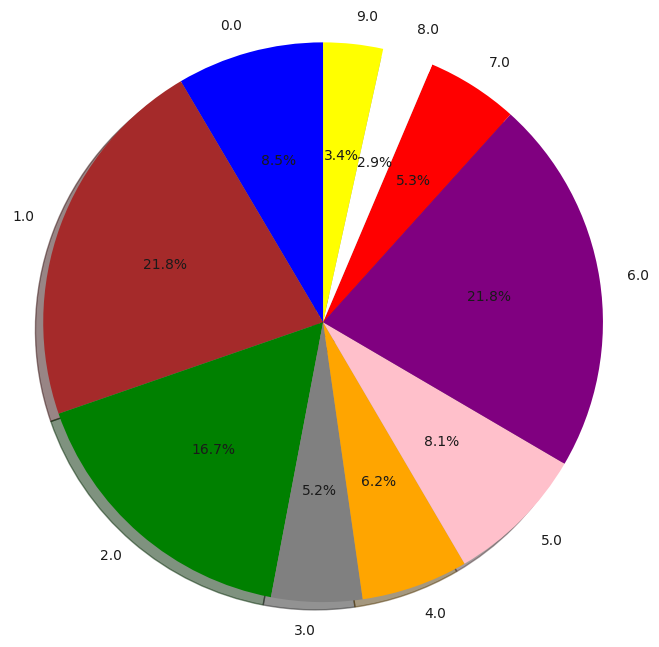

In [88]:
simulate_elections(predicted_y, 8)

##Clustering - Create count for each party in each cluster and then build parties preferences matrix

In [0]:
def calculate_parties_preferences(cluster_labels, valid_y, parties_size, clusters_count=30):
  # create clusters_array
  # 30X10 matrix in which every row is represents a cluster
  # and every col in this row means how many of this party (0,1,...,9) are in this cluster
  clusters_array = []
  clusters_array_for_count = []
  for count in xrange(clusters_count):
    clusters_array.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    clusters_array_for_count.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

  # fill clusters_array
  # each line in the array is a list of the parties dominancy inside the cluster.
  # the number is the party' dominancy in percentage (how many percent from the whole party is inside this cluster?)
  cluster_enum = zip(cluster_labels, valid_y[0])
  for gl, yl in cluster_enum:
    #print 'gl: ' + str(gl) + ' \t yl: ' + str(yl)
    # normalize count in the size of party: (1/parties_size[yl])
    clusters_array[gl.astype(int)][yl.astype(int)] += (1.0/parties_size[yl]) 
    clusters_array_for_count[gl.astype(int)][yl.astype(int)] += (1.0) 

  # create parties_pref
  # 10X10 matrix in which every row represents the party dist:
  # every col is a percentage that party shared with the other parties
  # example: row 0 means party 0, and col 3 means how much party 0 shared a cluster with party 3.
  parties_pref = []
  for c in xrange(10):
    parties_pref.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  parties_pref

  for parties_pref_row in range(len(parties_pref)):
    # iterate over big matrix clusters_array - and calc pref for each party (i.e each row in parties_pref)
    for i in range(len(clusters_array)):
      for j in range(len(clusters_array[i])):
        parties_pref[parties_pref_row][j] += (clusters_array[i][parties_pref_row] * clusters_array[i][j])

  parties_pref_final = [[], [], [], [], [], [], [], [], [], []]
  for i in range(len(parties_pref)):
    parties_pref_final[i] = [j[0] for j in sorted(enumerate(parties_pref[i]), key=lambda x:x[1], reverse=True)]

  # remove from each party preferences itself (since it can't build a coalition with itself)
  #parties_pref_final2 = parties_pref_final
  for i in range(len(parties_pref_final)):
    parties_pref_final[i].remove(i)  

  return parties_pref_final, clusters_array_for_count

In [90]:
# Create parties preferences according to the clusters and the presence of each party in every cluster
parties_preferences, clusters_array_for_count = calculate_parties_preferences(cluster_labels, valid_y, group_by_count(valid_y_values), clusters_number)
parties_preferences

[[9, 1, 2, 3, 4, 5, 6, 7, 8],
 [8, 5, 6, 2, 0, 3, 4, 7, 9],
 [5, 6, 1, 8, 0, 3, 4, 7, 9],
 [4, 7, 0, 1, 2, 5, 6, 8, 9],
 [3, 7, 0, 1, 2, 5, 6, 8, 9],
 [1, 8, 6, 2, 0, 3, 4, 7, 9],
 [8, 1, 5, 2, 0, 3, 4, 7, 9],
 [4, 3, 0, 1, 2, 5, 6, 8, 9],
 [1, 6, 5, 2, 0, 3, 4, 7, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8]]

In [91]:
# in this table we in row 0 how many from each party are in cluster #0 (81 from party-1, 33 from party-5, etc..)
clusters_array_for_count

[[0, 0, 0, 0, 0, 17.0, 2.0, 0, 12.0, 0],
 [0, 0, 58.0, 0, 0, 1.0, 1.0, 0, 0, 0],
 [0, 0, 0, 56.0, 59.0, 0, 0, 0, 0, 0],
 [0, 32.0, 0, 0, 0, 2.0, 75.0, 0, 9.0, 0],
 [0, 0, 0, 0, 48.0, 0, 0, 56.0, 0, 0],
 [22.0, 0, 0, 0, 0, 0, 0, 0, 0, 14.0],
 [0, 0, 0, 0, 0, 23.0, 0, 0, 0, 0],
 [0, 0, 48.0, 0, 0, 0, 0, 0, 0, 0],
 [0, 2.0, 0, 0, 0, 3.0, 169.0, 0, 5.0, 0],
 [0, 0, 65.0, 0, 0, 0, 0, 0, 0, 0],
 [0, 37.0, 0, 0, 0, 0, 1.0, 0, 6.0, 0],
 [0, 0, 0, 0, 0, 0, 9.0, 0, 0, 0],
 [6.0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0],
 [16.0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 50.0, 0, 0, 0, 0],
 [15.0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0],
 [0, 67.0, 71.0, 0, 0, 46.0, 77.0, 0, 11.0, 0],
 [11.0, 0, 0, 0, 0, 0, 0, 0, 0, 12.0],
 [0, 40.0, 0, 0, 0, 16.0, 0, 0, 4.0, 0],
 [0, 0, 0, 0, 0, 2.0, 64.0, 0, 1.0, 0],
 [0, 39.0, 0, 0, 0, 35.0, 3.0, 0, 6.0, 0],
 [59.0, 0, 0, 0, 0, 0, 0, 0, 0, 30.0],
 [0, 0, 0, 0, 0, 0, 7.0, 0, 0, 0],
 [0, 0, 0, 11.0, 0, 0, 0, 13.0, 0, 0],
 [0, 55.0, 0, 0, 0, 0, 1.0, 0, 13.0, 0],
 [0, 0, 0, 0, 0, 0, 3

##Build a Steady Coalition (given parties preferences and winning party)

In [0]:
from __future__ import division

def build_coalition(winning_party, parties_sizes, total_size, parties_preferences):
  # init the coalition with the winning_party
  coalition_array = []
  coalition_array.append(winning_party)
  coalition_size = parties_sizes[winning_party]
  i = 0
  coalition_percentage = (coalition_size / total_size)
  
  while coalition_percentage < 0.5:
    # add the next prefered party to the coalition
    coalition_array.append(parties_preferences[winning_party][i])
    coalition_size += parties_sizes[parties_preferences[winning_party][i]]
    coalition_percentage = (coalition_size / total_size)
    # increment the index in the parties_preferences of the winning_party
    i += 1
    
  print "Coalition Size: {0}".format(coalition_size)
  print "Coalition Percentage: {0}".format(coalition_percentage)
  print "Coalition Parties: {0} ({1})".format(coalition_array, [labels_dictionary[party] for party in coalition_array])
  return coalition_array, coalition_size, coalition_percentage

In [93]:
# build steady coalition
coalition_array, coalition_size, coalition_percentage = build_coalition(int(winning_party), parties_size, total_parties_size, parties_preferences)

Coalition Size: 1062
Coalition Percentage: 0.546296296296
Coalition Parties: [1, 8, 5, 6] (['Brown', 'White', 'Pink', 'Purple'])


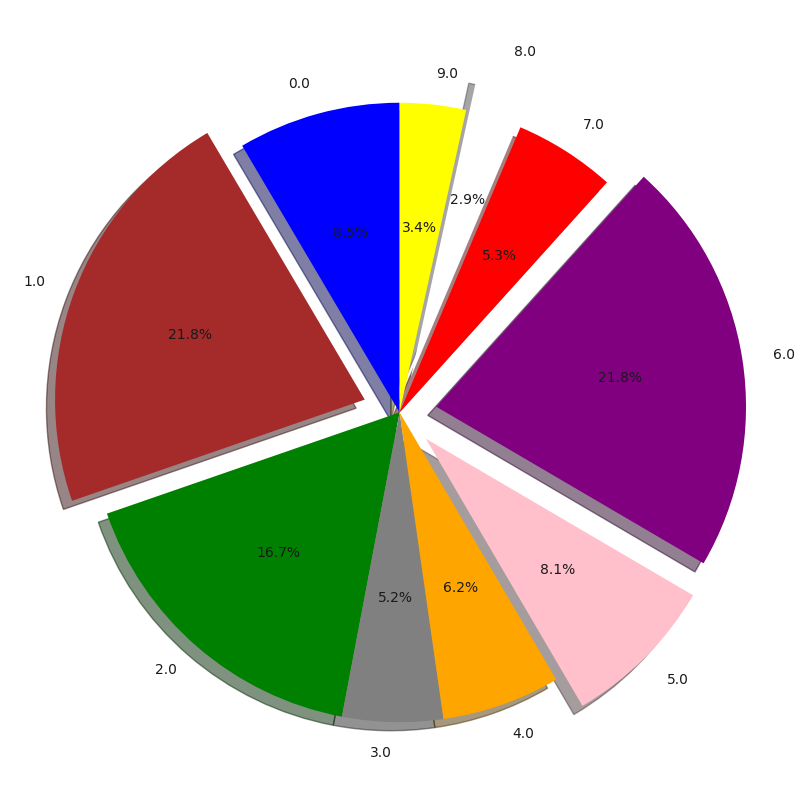

In [94]:
labels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ["blue", "brown", "green", "grey", "orange", "pink", "purple", "red", "white", "yellow"]
prediction_values = parties_size.values()

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
explode = (0.0, 0.12, 0.0, 0.0, 0.0, 0.12, 0.12, 0.0, 0.12, 0.0)

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(prediction_values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# 6. Significant features and manipulation

## Find general significant features which most likely to influence the label

Valid dataset features importance:
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  1944 non-null float64
Yearly_IncomeK                                   1944 non-null float64
Overall_happiness_score                          1944 non-null float64
Avg_Satisfaction_with_previous_vote              1944 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    1944 non-null float64
Weighted_education_rank                          1944 non-null float64
Will_vote_only_large_party_1.0                   1944 non-null int64
Will_vote_only_large_party_0.0                   1944 non-null int64
Will_vote_only_large_party_2.0                   1944 non-null int64
Most_Important_Issue_4.0                         1944 non-null int64
Most_Important_Issue_1.0                         1944 non-null int64
Most_Important_Issue_7.0                         194

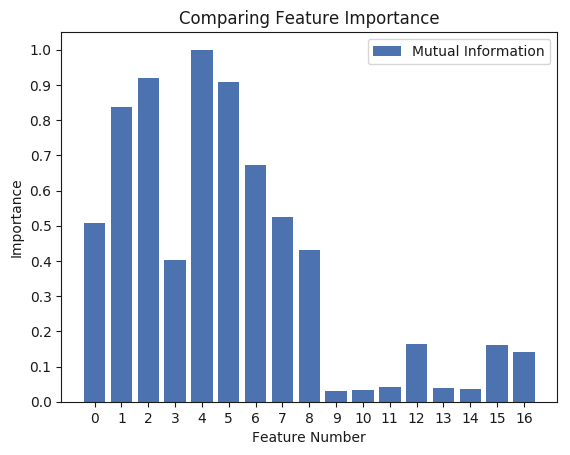

In [96]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression

plt.rcParams.update(plt.rcParamsDefault)

def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

def plot_feature_selection_comparision(X, MI_scores):
    X_indexes = np.arange(X.shape[-1])
    print X_indexes
    plt.bar(X_indexes, MI_scores, label="Mutual Information", color="b")
    plt.title("Comparing Feature Importance")
    plt.xlabel('Feature Number')
    plt.ylabel('Importance')
    plt.xticks(range(0, X.shape[-1]))
    plt.yticks(list(frange(0.0, 1.0, 0.1)))
    plt.legend(loc='upper right')
    plt.show()

def show_feature_importance(X, y):
  percentile = 100
   
  selector_mi = SelectPercentile(score_func=mutual_info_classif, percentile=percentile)
    
  selector_mi.fit(train_X, train_y)
  MI_scores = selector_mi.scores_
  MI_scores /= MI_scores.max()
  MI_features_percent = selector_mi.transform(train_X)
  print MI_features_percent.shape
  print MI_scores
  
  plot_feature_selection_comparision(train_X, MI_scores)
  
print "Valid dataset features importance:"
print "----------------------------------"
print valid_X.info()
show_feature_importance(valid_X, valid_y)

**We have 4 significant feature which have a value above 0.8 in the mutual information score function, the features are:**


1.   Yearly_IncomeK (0.83860384)
2.   Overall_happiness_score (0.91973599)
3.   Garden_sqr_meter_per_person_in_residancy_area (1.0)
4.   Weighted_education_rank (0.90815924)



## Find the leading features for each party

In [0]:
import operator
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

def get_ove_vs_all_label(y, party):
  y_ova = y.apply(lambda label: label == party)
  y_ova = y_ova.astype(float)
  return y_ova

def find_party_leading_features(party, X, y):
  clf = ExtraTreesClassifier()
  y_ova = get_ove_vs_all_label(y, party)
  model = clf.fit(X, y_ova)  
  model_feature_importance = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1], reverse=True)
  party_feature_importance = {}  
  for index, item in enumerate(model_feature_importance):
    importance = (item[0], round(item[1], 3))
    party_feature_importance[index] = importance
  return party_feature_importance

def display_party_feature_importance(party, party_feature_importance):
  print "Party {0} ({1})".format(party, labels_dictionary[party])
  print "--------------------"
  for index, feature in party_feature_importance.iteritems():
    print "Feature: {0}Score: {1}".format(feature[0].ljust(50), feature[1])
  print ""
    
def plot_party_leading_features(parties, leading_features):
  fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(30,5))
  fig.tight_layout()
  for i in parties:
    df = pd.DataFrame(leading_features[i].values(), columns=['Feature', 'Score'])
    axes[int(i)].bar(df['Feature'], df['Score'])
    axes[int(i)].set_title('Party Number ' + str(i))
    axes[int(i)].set_xlabel('Feature')
    axes[int(i)].set_ylabel('Score')
    axes[int(i)].set_xticklabels(df['Feature'], rotation=90)
  return
  

In [112]:
party_leading_features = {}

for party in labels_dictionary.keys():
  party_leading_features[party] = find_party_leading_features(party, train_X, train_y_values)
  display_party_feature_importance(party, party_leading_features[party])

Party 0.0 (Blue)
--------------------
Feature: Will_vote_only_large_party_2.0                    Score: 0.391
Feature: Avg_Satisfaction_with_previous_vote               Score: 0.209
Feature: Will_vote_only_large_party_0.0                    Score: 0.072
Feature: Overall_happiness_score                           Score: 0.067
Feature: Yearly_IncomeK                                    Score: 0.066
Feature: Weighted_education_rank                           Score: 0.06
Feature: Will_vote_only_large_party_1.0                    Score: 0.051
Feature: Garden_sqr_meter_per_person_in_residancy_area     Score: 0.043
Feature: Number_of_valued_Kneset_members                   Score: 0.025
Feature: Most_Important_Issue_1.0                          Score: 0.004
Feature: Most_Important_Issue_2.0                          Score: 0.003
Feature: Most_Important_Issue_7.0                          Score: 0.003
Feature: Most_Important_Issue_4.0                          Score: 0.002
Feature: Most_Important_Iss

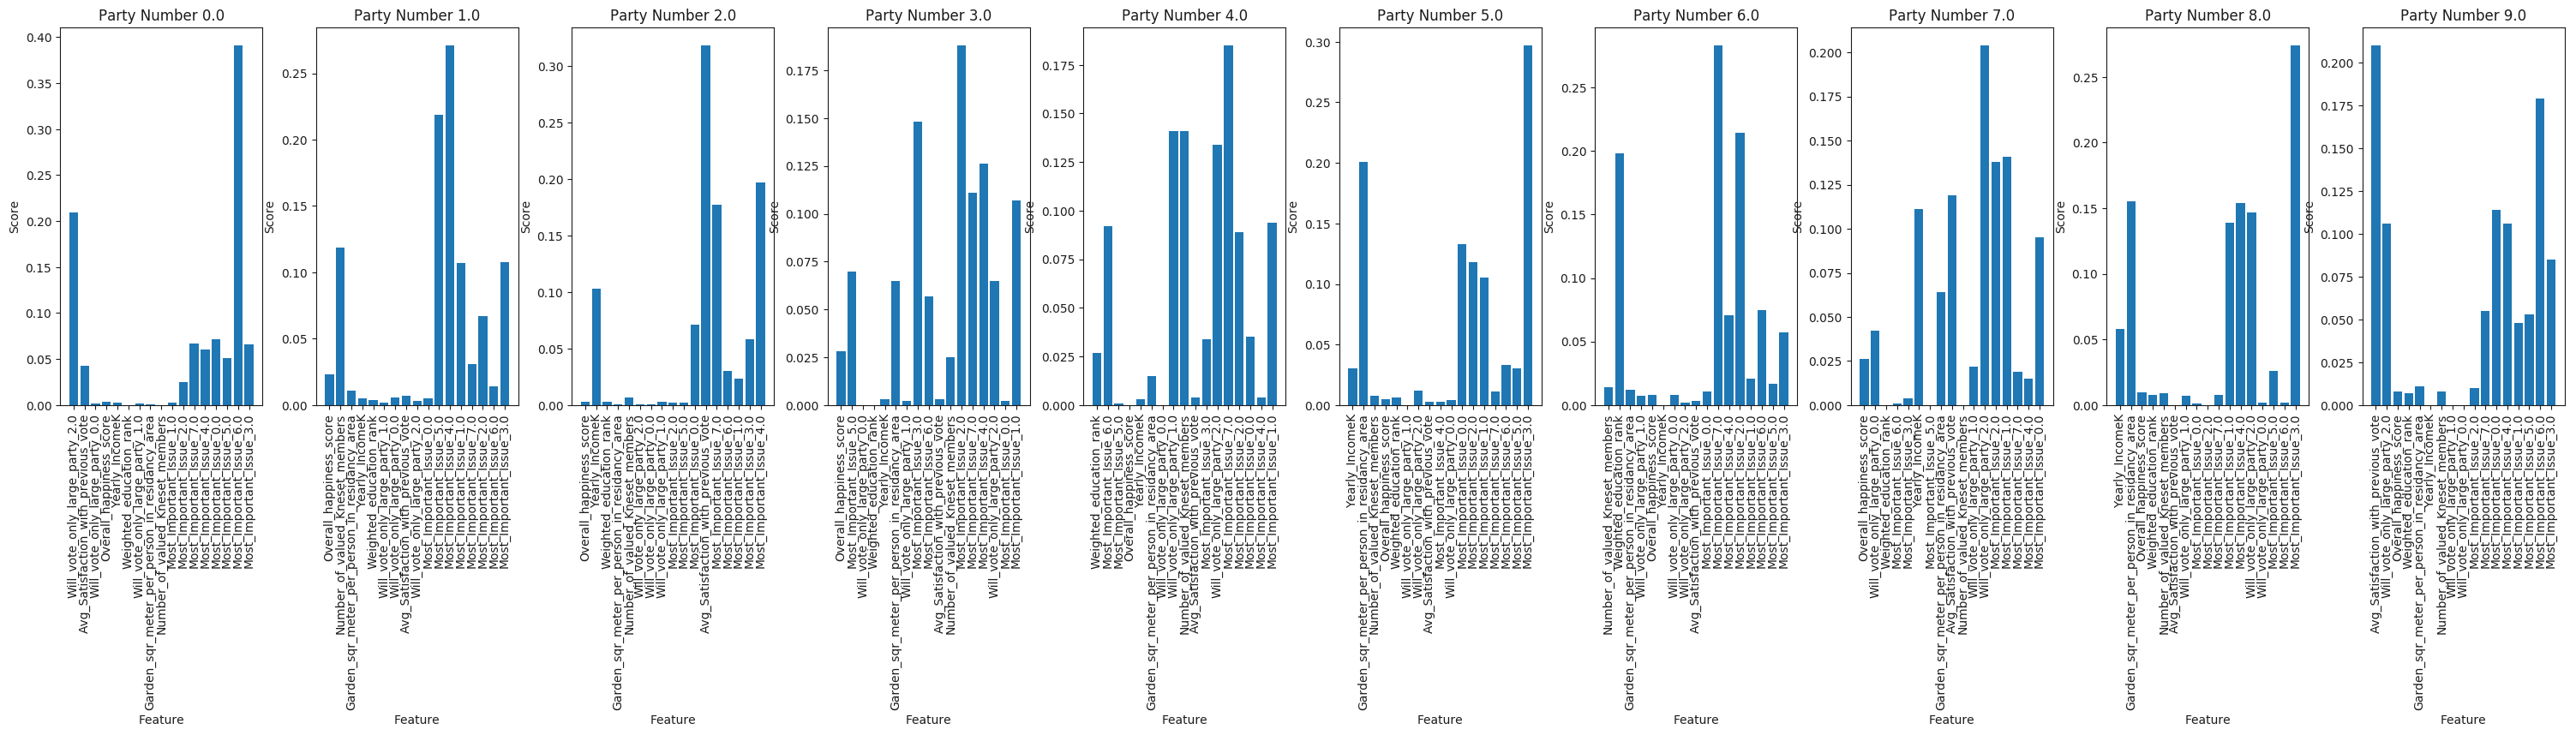

In [113]:
plot_party_leading_features(labels_dictionary.keys(), party_leading_features)

## Calculate key values of the leading features for each party

In [114]:
parties_dataframes = train_parties_dataframes_dictionary
party_key_values_for_leading_feature = {}

numerical_features = ["Yearly_IncomeK", 
                      "Overall_happiness_score", 
                      "Avg_Satisfaction_with_previous_vote", 
                      "Garden_sqr_meter_per_person_in_residancy_area", 
                      "Weighted_education_rank"]
categorical_features = ["Number_of_valued_Kneset_members", 
                        "Will_vote_only_large_party_1.0", 
                        "Will_vote_only_large_party_0.0", 
                        "Will_vote_only_large_party_2.0", 
                        "Most_Important_Issue_4.0", 
                        "Most_Important_Issue_1.0", 
                        "Most_Important_Issue_7.0", 
                        "Most_Important_Issue_5.0", 
                        "Most_Important_Issue_2.0", 
                        "Most_Important_Issue_0.0", 
                        "Most_Important_Issue_6.0",
                        "Most_Important_Issue_3.0"]



for party, leading_features in party_leading_features.iteritems():
  party_df = parties_dataframes[party]
  feature = leading_features[0][0]
  if feature in numerical_features:
    feature_key_values = (feature, party_df[feature].mean())
  elif feature in categorical_features:
    feature_key_values = (feature, party_df[feature].value_counts().idxmax())
  party_key_values_for_leading_feature[party] = feature_key_values
  
for party, key_values in party_key_values_for_leading_feature.iteritems():
  print "Party: {0} - {1}".format(party, key_values)

Party: 0.0 - ('Will_vote_only_large_party_2.0', 1)
Party: 1.0 - ('Overall_happiness_score', -0.591652184563494)
Party: 2.0 - ('Overall_happiness_score', 1.3977254283653757)
Party: 3.0 - ('Overall_happiness_score', -0.7103690069823408)
Party: 4.0 - ('Weighted_education_rank', -0.27662413551874215)
Party: 5.0 - ('Yearly_IncomeK', 1.031587204641732)
Party: 6.0 - ('Number_of_valued_Kneset_members', 12.0)
Party: 7.0 - ('Overall_happiness_score', -0.018221092944961787)
Party: 8.0 - ('Yearly_IncomeK', -0.568133103840402)
Party: 9.0 - ('Avg_Satisfaction_with_previous_vote', 0.9247195660014476)


##Manipulating party leading feature - Manipulating Elections (New winning part, Strengthen the coalition)

###Utilities

In [0]:
import random

def manipulate_feature(X, feature, value, percent):
  indexes = X.index
  samples_count = int(len(indexes) * percent)
  indexes_to_change = random.sample(indexes, samples_count)
  for index in indexes_to_change:
    X.at[index, feature] = value
  return X

###New winning party - 5.0 (Pink)

In [0]:
manipulated_valid_X = valid_X.copy()

In [0]:
# Lets make party 5 (Pink) the winning party
manipulated_valid_X = manipulate_feature(manipulated_valid_X, party_key_values_for_leading_feature[5.0][0], party_key_values_for_leading_feature[5.0][1], 1.0)

In [146]:
# Validate change to the valid dataset
print valid_X[party_key_values_for_leading_feature[5.0][0]].min(), valid_X[party_key_values_for_leading_feature[5.0][0]].mean(), valid_X[party_key_values_for_leading_feature[5.0][0]].max()
print manipulated_valid_X[party_key_values_for_leading_feature[5.0][0]].min(), manipulated_valid_X[party_key_values_for_leading_feature[5.0][0]].mean(), manipulated_valid_X[party_key_values_for_leading_feature[5.0][0]].max()

-4.40932486081 -0.012034117540966673 2.66430736784
1.031587204641732 1.0315872046417316 1.031587204641732


In [0]:
# Repredict elections scores 
manipulated_predicted_y = generative_model.predict(manipulated_valid_X)

Party | Count
----- | -----
0.0   | 153
1.0   | 23
2.0   | 330
3.0   | 174
4.0   | 143
5.0   | 476
6.0   | 376
7.0   | 8
8.0   | 182
9.0   | 79
----- | -----
Total | 1944

Winning Party: 5.0 (Pink)


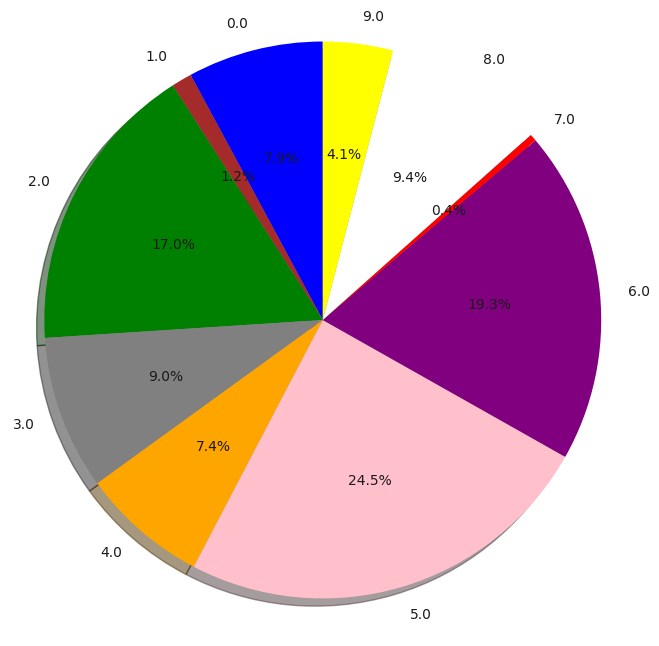

In [148]:
simulate_elections(manipulated_predicted_y, 8)

###Strengthen the coalition

In [0]:
manipulated_valid_X = valid_X.copy()

In [0]:
"""
Coalition Size: 1062
Coalition Percentage: 0.546296296296
Coalition Parties: [1, 8, 5, 6] (['Brown', 'White', 'Pink', 'Purple'])
"""

"""
Our coalition is combined from the parties (1.0, 8.0, 5.0, 6.0), and their most importance features are:
Party: 1.0 - ('Overall_happiness_score', -0.591652184563494)
Party: 5.0 - ('Yearly_IncomeK', 1.031587204641732)
Party: 6.0 - ('Number_of_valued_Kneset_members', 12.0)
Party: 8.0 - ('Yearly_IncomeK', -0.568133103840402)

We'll manipulate the data according to those features and their values
"""

coalition_parties = [1.0, 5.0, 6.0, 8.0]

for party in coalition_parties:
  manipulated_valid_X = manipulate_feature(manipulated_valid_X, party_key_values_for_leading_feature[party][0], party_key_values_for_leading_feature[party][1], 0.75)

In [133]:
# Validate change to the valid dataset

for party in coalition_parties:  
  print valid_X[party_key_values_for_leading_feature[party][0]].min(), valid_X[party_key_values_for_leading_feature[party][0]].mean(), valid_X[party_key_values_for_leading_feature[party][0]].max()
  print manipulated_valid_X[party_key_values_for_leading_feature[party][0]].min(), manipulated_valid_X[party_key_values_for_leading_feature[party][0]].mean(), manipulated_valid_X[party_key_values_for_leading_feature[party][0]].max()
  print ""

-4.42537983214 0.0107487358179901 2.54277728311
-4.246446543899999 -0.42903222063202084 2.46906467034

-4.40932486081 -0.012034117540966673 2.66430736784
-3.07615440109 -0.24529789965137233 2.43507188395

5.0 9.96193949528154 16.0
5.0 11.46820688096929 16.0

-4.40932486081 -0.012034117540966673 2.66430736784
-3.07615440109 -0.24529789965137233 2.43507188395



In [0]:
# Repredict elections scores 
manipulated_predicted_y = generative_model.predict(manipulated_valid_X)

Party | Count
----- | -----
0.0   | 161
1.0   | 417
2.0   | 38
3.0   | 136
4.0   | 128
5.0   | 274
6.0   | 644
7.0   | 61
8.0   | 14
9.0   | 71
----- | -----
Total | 1944



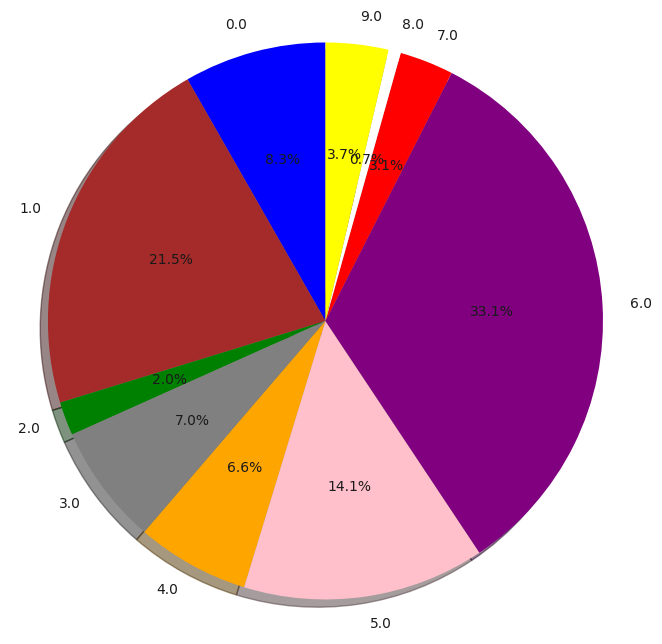

In [137]:
parties_size = get_parties_size(manipulated_predicted_y)
display_parties_votes(manipulated_predicted_y)
print ""
plot_parties_votes_pie(parties_size, 8)

In [143]:
strengthen_coalition_votes = 0
strengthen_coalition_percentage = 0

for party in coalition_parties:
  strengthen_coalition_votes += parties_size[party]
 
strengthen_coalition_percentage = round(float(strengthen_coalition_votes / sum(parties_size.values())), 2) * 100

print "Coalition Size: {0}".format(strengthen_coalition_votes)
print "Coalition Percentage: {0}".format(strengthen_coalition_percentage)
print "Coalition Parties: {0} ({1})".format(coalition_array, [labels_dictionary[party] for party in coalition_parties])

Coalition Size: 1349
Coalition Percentage: 69.0
Coalition Parties: [1, 8, 5, 6] (['Brown', 'Pink', 'Purple', 'White'])


#References

#### General

##### http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html
##### http://scikit-learn.org/stable/modules/model_evaluation.html - Best !
##### http://scikit-learn.org/stable/modules/cross_validation.html - Best !

##### http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics - Best !
##### http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py - Best !
##### http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py
##### http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score
##### http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
##### http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
##### http://www.ritchieng.com/machine-learning-evaluate-classification-model/
##### http://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/
##### http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings

#### GMM
http://scikit-learn.org/stable/modules/mixture.html#mixture
http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py

How to draw circules aroud the clusters:
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

# NOTES

In [0]:
# HERE ARE THE DATA SETS TO DOWNLOAD FROM DRIVE:

#ElectionsData.csv
#https://drive.google.com/open?id=1Xdsqn2C0XR8AQnRfkWpU2JBQfK2rURe_

## NEW AFTER FIX -1:

#test_X.csv
#https://drive.google.com/open?id=10F4pfym7OgqvT1xu6Bo27WqpZjsGhhih

#test_y.csv
#https://drive.google.com/open?id=1uGX6RQFot5gww3vExfpeg1GFR8ZMFYPX

#train_X.csv
#https://drive.google.com/open?id=1mwrxBXZsgHLFO9IpWYXNfUFJnLT5yraj

#train_y.csv
#https://drive.google.com/open?id=1FHPumn9bdXiLzO5tbpGGrcvxzNpoCG0Z

#validation_X.csv
#https://drive.google.com/open?id=1HgtZC1iq9VYH8Ygo6-6XnC6G0xa8Lz01

#validation_y.csv
#https://drive.google.com/open?id=1Z_0zOORoZJVlOQ58UdXml4maSNSNBBMK

#Valid_X_with_Predicted_Vote.csv
#https://drive.google.com/open?id=1FHPumn9bdXiLzO5tbpGGrcvxzNpoCG0Z